# Collaborative Filtering
These are notes from lesson 7 of Fast AI Practical Deep Learning for Coders.

::: {.callout-tip title="Homework Task"}
- Create a collaborative filtering model in a [spreadsheet](https://docs.google.com/spreadsheets/d/1tIzbgwu3qmAJounfKtr4n-uwAkupetmVqkHAWllYRDw/edit?usp=sharing)
:::

## 1. The Intuition Behind Collaborative Filtering
We have users ratings of movies. 

Say we had “embeddings” of a set of categories for each. So for a given **movie**, we have a vector of `[action, sci-fi, romance]` and for a given **user** we have their preference for `[action, sci-fi, romance]`. Then we could do the dot product between user embedding and movie embedding to get the probability that the user likes that movie. That is, the predicted user rating. 

So the problem boils down to: 

1. What are the embeddings? i.e. the salient factors (`[action, sci-fi, romance]` in the example above)
2. How do we get them?

The answer to both questions is: we just let the model learn them.

Let’s just pick a randomised embedding for each movie and each user. Then we have a loss function which is the MAE between predicted user rating for a movie and actual rating. 
Now we can use SGD to optimise those embeddings to find the best values. 


## 2. A deep learning spreadsheet (!)
To gain an intuition behind the calculations behind a collaborative filter, we can work through a (smaller) example in excel. 
This allows us to see the logic and dig into the calculations before we create them "for real" in Python.

::: {.callout-tip}
This can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1tIzbgwu3qmAJounfKtr4n-uwAkupetmVqkHAWllYRDw/edit?usp=sharing).
:::

We first look at an example where the results are in a cross-table and we can take the dot product of user embeddings and movie embeddings.

Then we reshape the problem slightly by placing all of the embeddings in a matrix and doing a lookup. This is essentially what pytorch does, although it uses matrix multiplication by one-hot encoded vectors rather than array lookups for computational efficiency.

We then add a bias term to account for some users who love all movies, or hate all movies. And also movies that are universally beloved.

## 3. Input Data and Factors

The broad idea behind collaborative filtering is:

- If we could quantify the most salient "latent factors" about a movie, and...
- Quantify how much a user cares about that factor, then...
- If we multiplied the two (dot product) it would give a measure of their rating.

But what are those latent factors? We let the model learn it. 
1. We initialise randomised latent factors (called embeddings)
2. We use that to predict the user's rating for each move. Initially, those randomised weights will give terrible predictions.
3. Our loss function is the MSE of the ground truth actual predictions and the prediction rating.
4. We can optimise the embedding values to minimise this loss function.

### 3.1. Loading MovieLens data
We use data on user ratings of movies sourced from [MovieLens](https://grouplens.org/datasets/movielens/).
The `ml-latest-small` data set is downloaded and saved in the `DATA_DIR` folder.

In [68]:
from pathlib import Path

from fastai.collab import CollabDataLoaders, Module, Embedding, collab_learner
from fastai.tabular.all import one_hot, sigmoid_range, MSELossFlat, Learner, get_emb_sz
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 
import torch


DATA_DIR = Path("/Users/gurpreetjohl/workspace/python/ml-practice/ml-practice/datasets/ml-latest-small")

Load the `ratings` data which we will use for this task:

In [3]:
ratings = pd.read_csv(DATA_DIR / 'ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


The users and movies are encoded as integers. 

For reference, we can load the `movies` data to see what each `movieId` corresponds to:

In [4]:
movies = pd.read_csv(DATA_DIR / 'movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


We'll merge the two for easier human readability.

In [5]:
ratings = ratings.merge(movies)
ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


### 3.2 Prepare the Data

In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,userId,title,rating
0,4,Mighty Aphrodite (1995),3.0
1,573,"Dark Knight, The (2008)",5.0
2,116,Amadeus (1984),3.0
3,380,"Addams Family, The (1991)",5.0
4,353,"Brothers McMullen, The (1995)",4.0
5,37,"Fugitive, The (1993)",4.0
6,356,Unbreakable (2000),4.0
7,489,Alien³ (a.k.a. Alien 3) (1992),3.5
8,174,Nell (1994),5.0
9,287,Panic Room (2002),2.5


Initialise randomised 5-dimensional embeddings.

How should we choose the number of latent factors? (5 in the example above).
Jeremy wrote down some ballpark values for models of different sizes in excel, then fit a function to it to get a heuristic measure. This is the default used by fast AI. 


In [7]:
n_users  = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

Doing a matrix multiply by a one hot encoded vector is the same as doing a lookup in an array, just in a more computationally efficient way. Recall the softmax example. 

An embedding is essentially just “look up in an array”. 



## 4. Building a Collaborative Filter From Scratch

Putting a sigmoid_range on the final layer to squish ratings to fit 0 to 5 means “the model doesn’t have to work as hard” to get movies in the right range. 
In practice we use 5.5 as the sigmoid scale value as a sigmoid can never hit 1, but we want ratings to be able to hit 5. 


In [8]:
from fastai.collab import CollabDataLoaders, Module, Embedding
from fastai.tabular.all import one_hot, sigmoid_range, MSELossFlat, Learner

In [9]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        # Apply a sigmoid to the raw_output
        raw_output = (users * movies).sum(dim=1)
        return sigmoid_range(raw_output, *self.y_range)

We can now fit a model

In [10]:
embedding_dim = 50
num_epochs = 5
max_learning_rate = 5e-3

model = DotProduct(n_users, n_movies, embedding_dim)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(num_epochs, max_learning_rate)

### 4.2. Adding a bias term
Adding a user bias term and a movie bias term to the prediction call helps account for the fact that some users always rate high (4 or 5) but other users always rate low. And similarly for movies if everyone always rates it a 5 or a 1. 

In [11]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        raw_output = (users * movies).sum(dim=1, keepdim=True)
        raw_output += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(raw_output, *self.y_range)

In [12]:
model = DotProductBias(n_users, n_movies, embedding_dim)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(num_epochs, max_learning_rate)

epoch,train_loss,valid_loss,time


### 4.3. Weight Decay
The validation loss in the previous model decreases then icnreases, which is a clear indication of overfitting.

We want to avoid overfitting, but data augmentation isn’t possible here. One approach is to use **weight decay** AKA L2 regularisation. We add sum of weights squared to the loss function.

How does this prevent overfitting? The larger the coefficients, the sharper the canyons the model is able to produce, which allows it to fit individual data points. By penalising larger weights, it will only produce sharp changes if this causes the model to fit many points well, so it should generalise better.

We essentially want to modify our loss function with an additional term dependent on the magnitude of the weights:

```
loss_with_weight_decay = loss + weight_decay * (parameters**2).sum()
```

In practice, these values would be large and numerically unstable. We only actually care about the *gradient* of the loss, so we can add the gradient of the additional term to the existing gradient.
```
parameters.grad += weight_decay * 2 * parameters
```

But `weight_decay` is just a constant that we choose, so we can fold the `2*` term into it.

In [13]:
weight_decay = 0.1

model = DotProductBias(n_users, n_movies, embedding_dim)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(num_epochs, max_learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time


### 4.3. Creating our own Embedding module
In the previous section, we used that pytorch (technically the fastai version) Embedding module. 

Let's briefly take a look at this and create our own Embedding module from scratch.

#### 4.3.1. Parameters
The way pytorch knows if a tensor is a parameter (and therefore can calculate gradients on it) is if it inherits from `nn.Parameter`.
Then a Module’s `.parameters()` method will list this tensor. 

As an example of this behaviour, let's create a module with some parameters but WITHOUT declaring these as Parameters:

In [17]:
class MyModule(Module):
    def __init__(self): 
        self.a = torch.ones(3)

mm = MyModule()
list(mm.parameters())

[]

We declared a tensor `a` in MyModule but we don't see it! Which means it wouldn't be trained by Pytorch.

Instead, let's declare is as a Parameter:

In [21]:
class MyModuleWithParams(Module):
    def __init__(self): 
        self.a = torch.nn.Parameter(torch.ones(3))

mm_params = MyModuleWithParams()
list(mm_params.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True)]



Pytorch's builtin modules all use `Parameter` for any  trainable parameters, so we haven't needed to explicitly declare this.

As an example, if we use Pytorch's `Linear` layer, it will automatically appear as a parameter:

In [22]:
class MyModuleWithLinear(Module):
    def __init__(self): 
        self.a = torch.nn.Linear(1, 3, bias=False)

mm_linear = MyModuleWithLinear()
list(mm_linear.parameters())

[Parameter containing:
 tensor([[-0.6689],
         [-0.0181],
         [ 0.8172]], requires_grad=True)]

In [24]:
type(mm_linear.a.weight)

torch.nn.parameter.Parameter

#### 4.3.2. The `Embedding` module

An `Embedding` object essentially instantiates a tensor of random weights of the given dimensions and declares this as a `Parameter`.
Pytorch can then modify the weights when training.

In [34]:
def create_params(tensor_dims):
    """Create a tensor of the required size and fill it with random values."""
    embedding_tensor = torch.zeros(*tensor_dims).normal_(0, 0.01)
    return torch.nn.Parameter(embedding_tensor)

Now we can replace the import `Embedding` module with our custom implementation `create_params` in the `DotProductBias` module:

In [39]:
class DotProductBiasCustomEmbedding(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        raw_output = (users * movies).sum(dim=1)
        raw_output += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(raw_output, *self.y_range)


In [40]:
model = DotProductBiasCustomEmbedding(n_users, n_movies, embedding_dim)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(num_epochs, max_learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time
0,0.795456,0.787701,00:07
1,0.693971,0.728376,00:06
2,0.546227,0.711909,00:07
3,0.402994,0.707349,00:06
4,0.282765,0.708693,00:06


### 4.4. Interpreting Embeddings and Biases

We can interrogate the model to learn more about these embeddings it has learned.

#### 4.4.1. Biases

We can visualise the biases of our collaborative filter model to see:

- **Movie biases**: Which movies are bad even compared to other similar movies of that type? Lawnmower man 2 is crap even compared to similar action movies. But people love titanic even if they don’t normally like romance dramas. 
- **User biases**: Which users love any and all movies? Users who give a high rating to all movies.


According to our biases, these movies are crap even for those who like that style of movie:

In [41]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Karate Kid, Part III, The (1989)',
 'Catwoman (2004)',
 'Stuart Saves His Family (1995)',
 'Speed 2: Cruise Control (1997)',
 'Dungeons & Dragons (2000)']

Whereas these are highly rated, even when users don't normally like that type of movie:

In [42]:
idxs = movie_bias.argsort()[-5:]
[dls.classes['title'][i] for i in idxs]

['Star Wars: Episode IV - A New Hope (1977)',
 'Dark Knight, The (2008)',
 'Green Mile, The (1999)',
 'Forrest Gump (1994)',
 'Shawshank Redemption, The (1994)']

#### 4.4.2. Weights
We can visualise the weights to see what human-interpretable features the model is learning. 

We can condense our embedding to 2 axes with PCA. we get a `critically-acclaimed -> popular` x-axis and a action-dialog y-axis. 

::: {.callout-tip}
For more details on PCA and related methods, see [computational linear algebra fastai course](https://github.com/fastai/numerical-linear-algebra)
:::

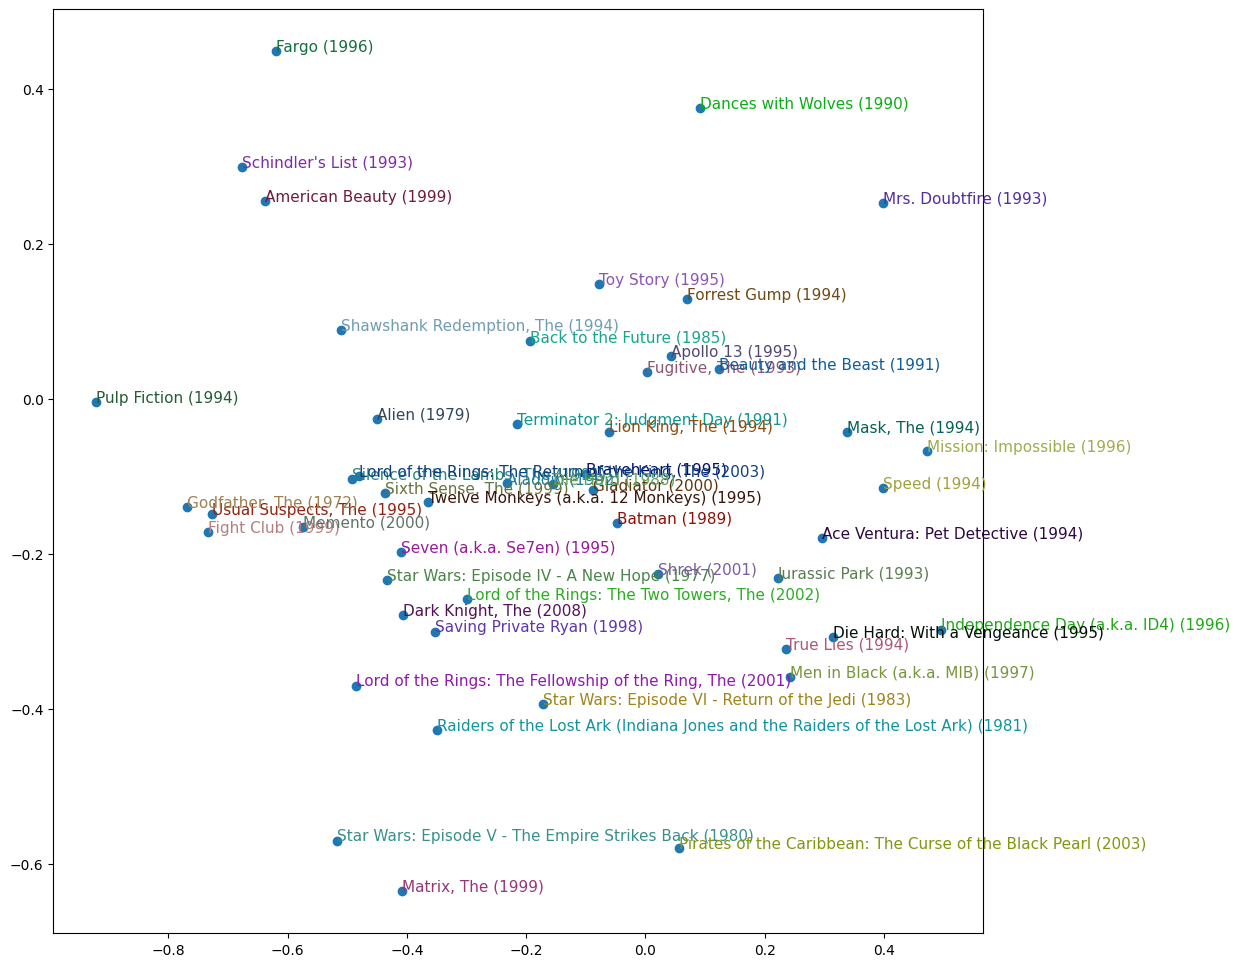

In [48]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = torch.tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

#### 4.4.3. Embedding Distance

We can also use the “embedding distance” (distance in the latent space) to see when two movies are similar. We use cosine similarity to determine this distance, which is similar in principle to Euclidean distance but normalised. 

In the example below, we start with the movie *Forrest Gump* and find the closest movie to it in our embedding:

In [66]:
movie_idx = dls.classes['title'].o2i['Forrest Gump (1994)']

movie_factors = learn.model.movie_factors
distances = torch.nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[movie_idx][None])
closest_distance_idx = distances.argsort(descending=True)[1]
dls.classes['title'][closest_distance_idx]

'Beautiful Mind, A (2001)'

## 5. Building a Collaborative Filter with Fastai's Library

We can repeat the same exercise using the collaborative filter from the fastai library to see how it compares to our from-scratch implementation.

In [69]:
learn_fast = collab_learner(dls, n_factors=embedding_dim, y_range=(0, 5.5))
learn_fast.fit_one_cycle(num_epochs, max_learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time


We can repeat any of the analysis of our from-scratch model. For example, the movies with the highest bias:

In [70]:
movie_bias = learn_fast.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Green Mile, The (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Dark Knight, The (2008)']

## 6. Bootstrapping a Collaborative Filtering Model

How do you start off a collaborative filtering model? For example, when you first start out, you have no data on users or items.

Or even for established companies, what happens when we have a new user or a new item, so the entire row or column is null?

There is no hard and fast solution, they all boil down to "use common sense".

- A tempting option is to fill NaNs with the *median latent vectors*. But this might result in an odd combination that doesn't exist in practice, i.e. the latent space isn't continuous so this could be where a gap in the latent space lies. For example, a medium action, medium sci-fi film with medium romance and medium comedy that is medium popular and medium critically acclaimed.
- Another option is to pick a user/item that is representative of the *average* taste.
- Create a *tabular model* using answers to a new user survey. Ask the user some questions when they sign up, then create a model where the user's embedding vector is the dependent variable and their answers, along with any other relevant signup metadata, are the independent variables.

It is important to be careful of a small number of extremely enthusiastic users dominating the recommendations. For example, people who watch anime watch a LOT of it, and rate a lot of it highly. So this could end up getting recommended to users outside of this niche.

This can create positive feedback loops that change the behaviour of your product in unexpected ways.

## 7. Deep Learning for Collaborative Filtering

The matrix completion approach used previously is known as **Probabilistic Matrix Factorization (PMF)**.
An alternative approach is to use **deep learning**.

In practice the two approaches are often stacked in an ensemble.

This section explores the deep learning collaborative filtering approach from scratch, then recreates it using fastai's library.


### 7.1. Building a Deep Learning Collaborative Filter From Scratch
We are concatenating the embedding matrices together, rather than taking the dot product, so that we can pass it through a dense ANN.

These matrices can be different sizes, and the size of embedding to use for each depends on the number of classes in the data. Fastai has a heuristic method for this which we use here:


In [77]:
(user_num_classes, user_num_embeddings), (item_num_classes, item_num_embeddings) = get_emb_sz(dls)

We can then use this in a simple neural network with one hidden layer:

In [ ]:
class CollabNN(Module):
    def __init__(self, user_embedding_size, item_embedding_size, y_range=(0, 5.5), n_activations=100):
        self.user_factors = Embedding(*user_embedding_size)
        self.item_factors = Embedding(*item_embedding_size)
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(user_embedding_size[1] + item_embedding_size[1], n_activations),
            torch.nn.ReLU(),
            torch.nn.Linear(n_activations, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:, 0]), self.item_factors(x[:, 1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)
    
collab_nn_model = CollabNN(user_embedding_size=(user_num_classes, user_num_embeddings),
                           item_embedding_size=(item_num_classes, item_num_embeddings))

Now train this model on the data:

In [95]:
learn_nn = Learner(dls, collab_nn_model, loss_func=MSELossFlat())
learn_nn.fit_one_cycle(num_epochs, max_learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time
0,0.799004,0.792579,00:10
1,0.747623,0.755708,00:10
2,0.706981,0.723887,00:10
3,0.650337,0.719642,00:10
4,0.569418,0.734302,00:10


### 7.2. Building a Deep Learning Collaborative Filter with Fastai's Library

We can repeat the same exercise using fastai's implementation.

This is almost identical to the PMF approach, simply with an additional argument `use_nn=True`.

In [96]:
learn_nn_fast = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100, 50])
learn_nn_fast.fit_one_cycle(num_epochs, max_learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time
0,0.838047,0.801519,00:14
1,0.761085,0.744033,00:12
2,0.709788,0.734091,00:13
3,0.653415,0.728950,00:13
4,0.545074,0.743957,00:12


## 8. Summary

The recommender problem is one where we have some users and their ratings of some items. We want to know which unseen items a user may like.

We implemented two approaches to collaborative filtering:

1. Probabilistic Matrix Factorization (PMF)
2. A neural network

For each approach, we build a model from scratch in Pytorch, then compared that with fastai's implementation. For the PMF approach, we even gained some intuition by creating a spreadsheet implementation first!

In practice, both approaches can be stacked for improved recommendations.


## References
- [Course lesson page](https://course.fast.ai/Lessons/lesson7.html)
- [Collaborative filtering notebook](https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive/notebook)
- [Computational linear algebra fastai course](https://github.com/fastai/numerical-linear-algebra)
